In [1]:
!pip install gtts

In [2]:
import os
import random
import pickle
import warnings
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, BatchNormalization, RepeatVector, Dot, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input 
from tensorflow.keras.layers import Add
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import History
from nltk.translate.bleu_score import corpus_bleu

warnings.filterwarnings("ignore", category=FutureWarning)

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from gtts import gTTS
from IPython.display import Audio, display


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
BASE_DIR = '/kaggle/input/flickr30k'
WORKING_DIR = '/kaggle/working'


# Caption Preprocessing:

In [4]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)


def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)


100%|██████████| 158916/158916 [00:00<00:00, 720380.36it/s]


In [5]:
example_keys = list(mapping.keys())[:2]  
for key in example_keys:
    print(f"Image ID: {key}")
    for caption in mapping[key]:
        print(f"Cleaned Caption: {caption}")
    print("-" * 50)  


Image ID: 1000092795
Cleaned Caption: startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq
Cleaned Caption: startseq two young white males are outside near many bushes ." endseq
Cleaned Caption: startseq two men in green shirts are standing in yard endseq
Cleaned Caption: startseq man in blue shirt standing in garden endseq
Cleaned Caption: startseq two friends enjoy time spent together endseq
--------------------------------------------------
Image ID: 10002456
Cleaned Caption: startseq several men in hard hats are operating giant pulley system endseq
Cleaned Caption: startseq workers look down from up above on piece of equipment endseq
Cleaned Caption: startseq two men working on machine wearing hard hats endseq
Cleaned Caption: startseq four men on top of tall structure endseq
Cleaned Caption: startseq three men on large rig endseq
--------------------------------------------------


# Text Tokenization:

In [6]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))


In [7]:
len(all_captions)

158915

In [8]:
vocab_size

18314

# Splitting Dataset:

In [9]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

print("Number of training samples:", len(train))
print("Number of testing samples:", len(test))

max_length = max(len(caption.split()) for caption in all_captions)
print("Maximum Caption Length:",(max_length))


Number of training samples: 28604
Number of testing samples: 3179
Maximum Caption Length: 75


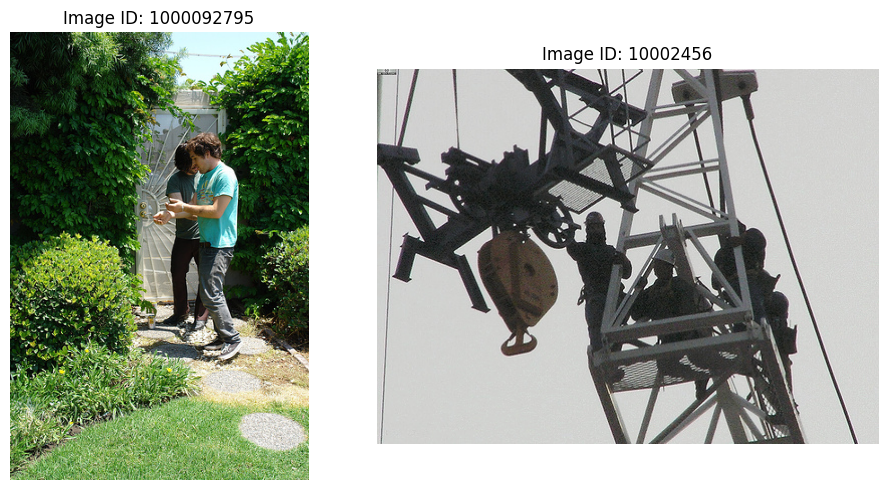

In [10]:
IMAGES_DIR = os.path.join(BASE_DIR, 'Images','flickr30k_images')

image_files = list(mapping.keys())[:2]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

for i, image_id in enumerate(image_files):
    image_path = os.path.join(IMAGES_DIR, image_id + '.jpg')  
    if os.path.exists(image_path): 
        img = mpimg.imread(image_path)
        axes[i].imshow(img) 
        axes[i].set_title(f"Image ID: {image_id}")
        axes[i].axis('off')  
    else:
        print(f"Image {image_id}.jpg not found in the dataset.")

plt.tight_layout() 
plt.show()


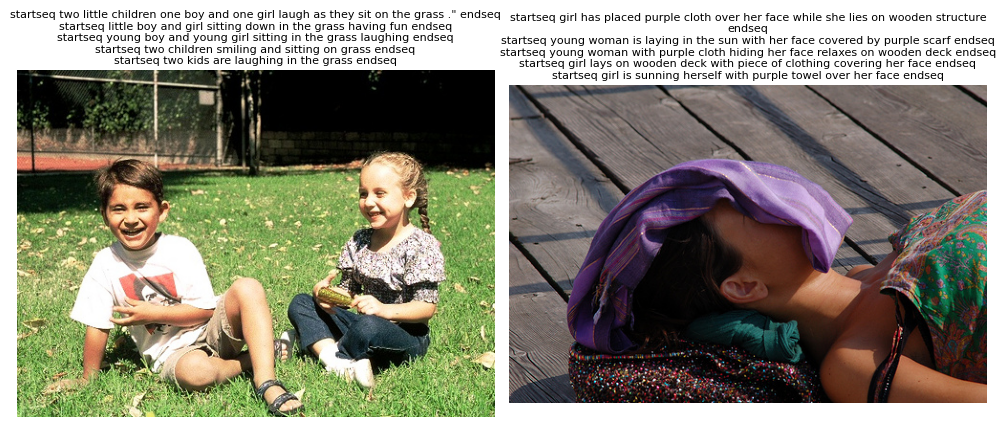

In [11]:
def display_random_images(directory, mapping, num_images=2):
   
    image_ids = random.sample(list(mapping.keys()), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    
    for i, image_id in enumerate(image_ids):
        img_path = os.path.join(directory, image_id + '.jpg') 
        
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            
            axes[i].imshow(img)
            axes[i].axis('off')  
            
            captions = mapping[image_id]
            caption_text = "\n".join(captions)
            axes[i].set_title(caption_text, fontsize=8, wrap=True)
        else:
            axes[i].axis('off')  
            axes[i].set_title(f"Image {image_id}.jpg not found.", fontsize=12)
    
    plt.tight_layout()
    plt.show()


image_directory = os.path.join(BASE_DIR, 'Images','flickr30k_images')
display_random_images(image_directory, mapping)


So, here we are done with Captions:
1. Mapping
2. Cleaning
3. Tokenizing 

# MODEL:

# MobileNet V3 Large:

In [12]:
MBmodel = MobileNetV3Large(weights='imagenet', include_top=True)
model = Model(inputs=MBmodel.inputs, outputs=MBmodel.layers[-2].output)
#print(model.summary())


/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


22661472/22661472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:

features2 = {}
directory = os.path.join(BASE_DIR, 'Images','flickr30k_images') 

valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']


for img_name in tqdm(os.listdir(directory)):
    
    file_extension = os.path.splitext(img_name)[1].lower()

    if file_extension in valid_extensions:
        try:
            
            img_path = os.path.join(directory, img_name)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            
            feature2 = model.predict(image, verbose=0)
            image_id = img_name.split('.')[0]
            features2[image_id] = feature2


        except UnidentifiedImageError:
            print(f"Could not identify image file: {img_name}")
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    else:
        print(f"Skipping non-image file: {img_name}")


  0%|          | 0/31783 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1733232719.855926      79 service.cc:145] XLA service 0x7e9490002a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733232719.855981      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733232719.855984      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733232724.223574      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 31783/31783 [39:12<00:00, 13.51it/s]


In [14]:
pickle.dump(features2, open(os.path.join(WORKING_DIR, 'MobileNetV3featuresF.pkl'), 'wb'))


In [15]:
def data_generator2(data_keys, mapping, features2, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features2[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0


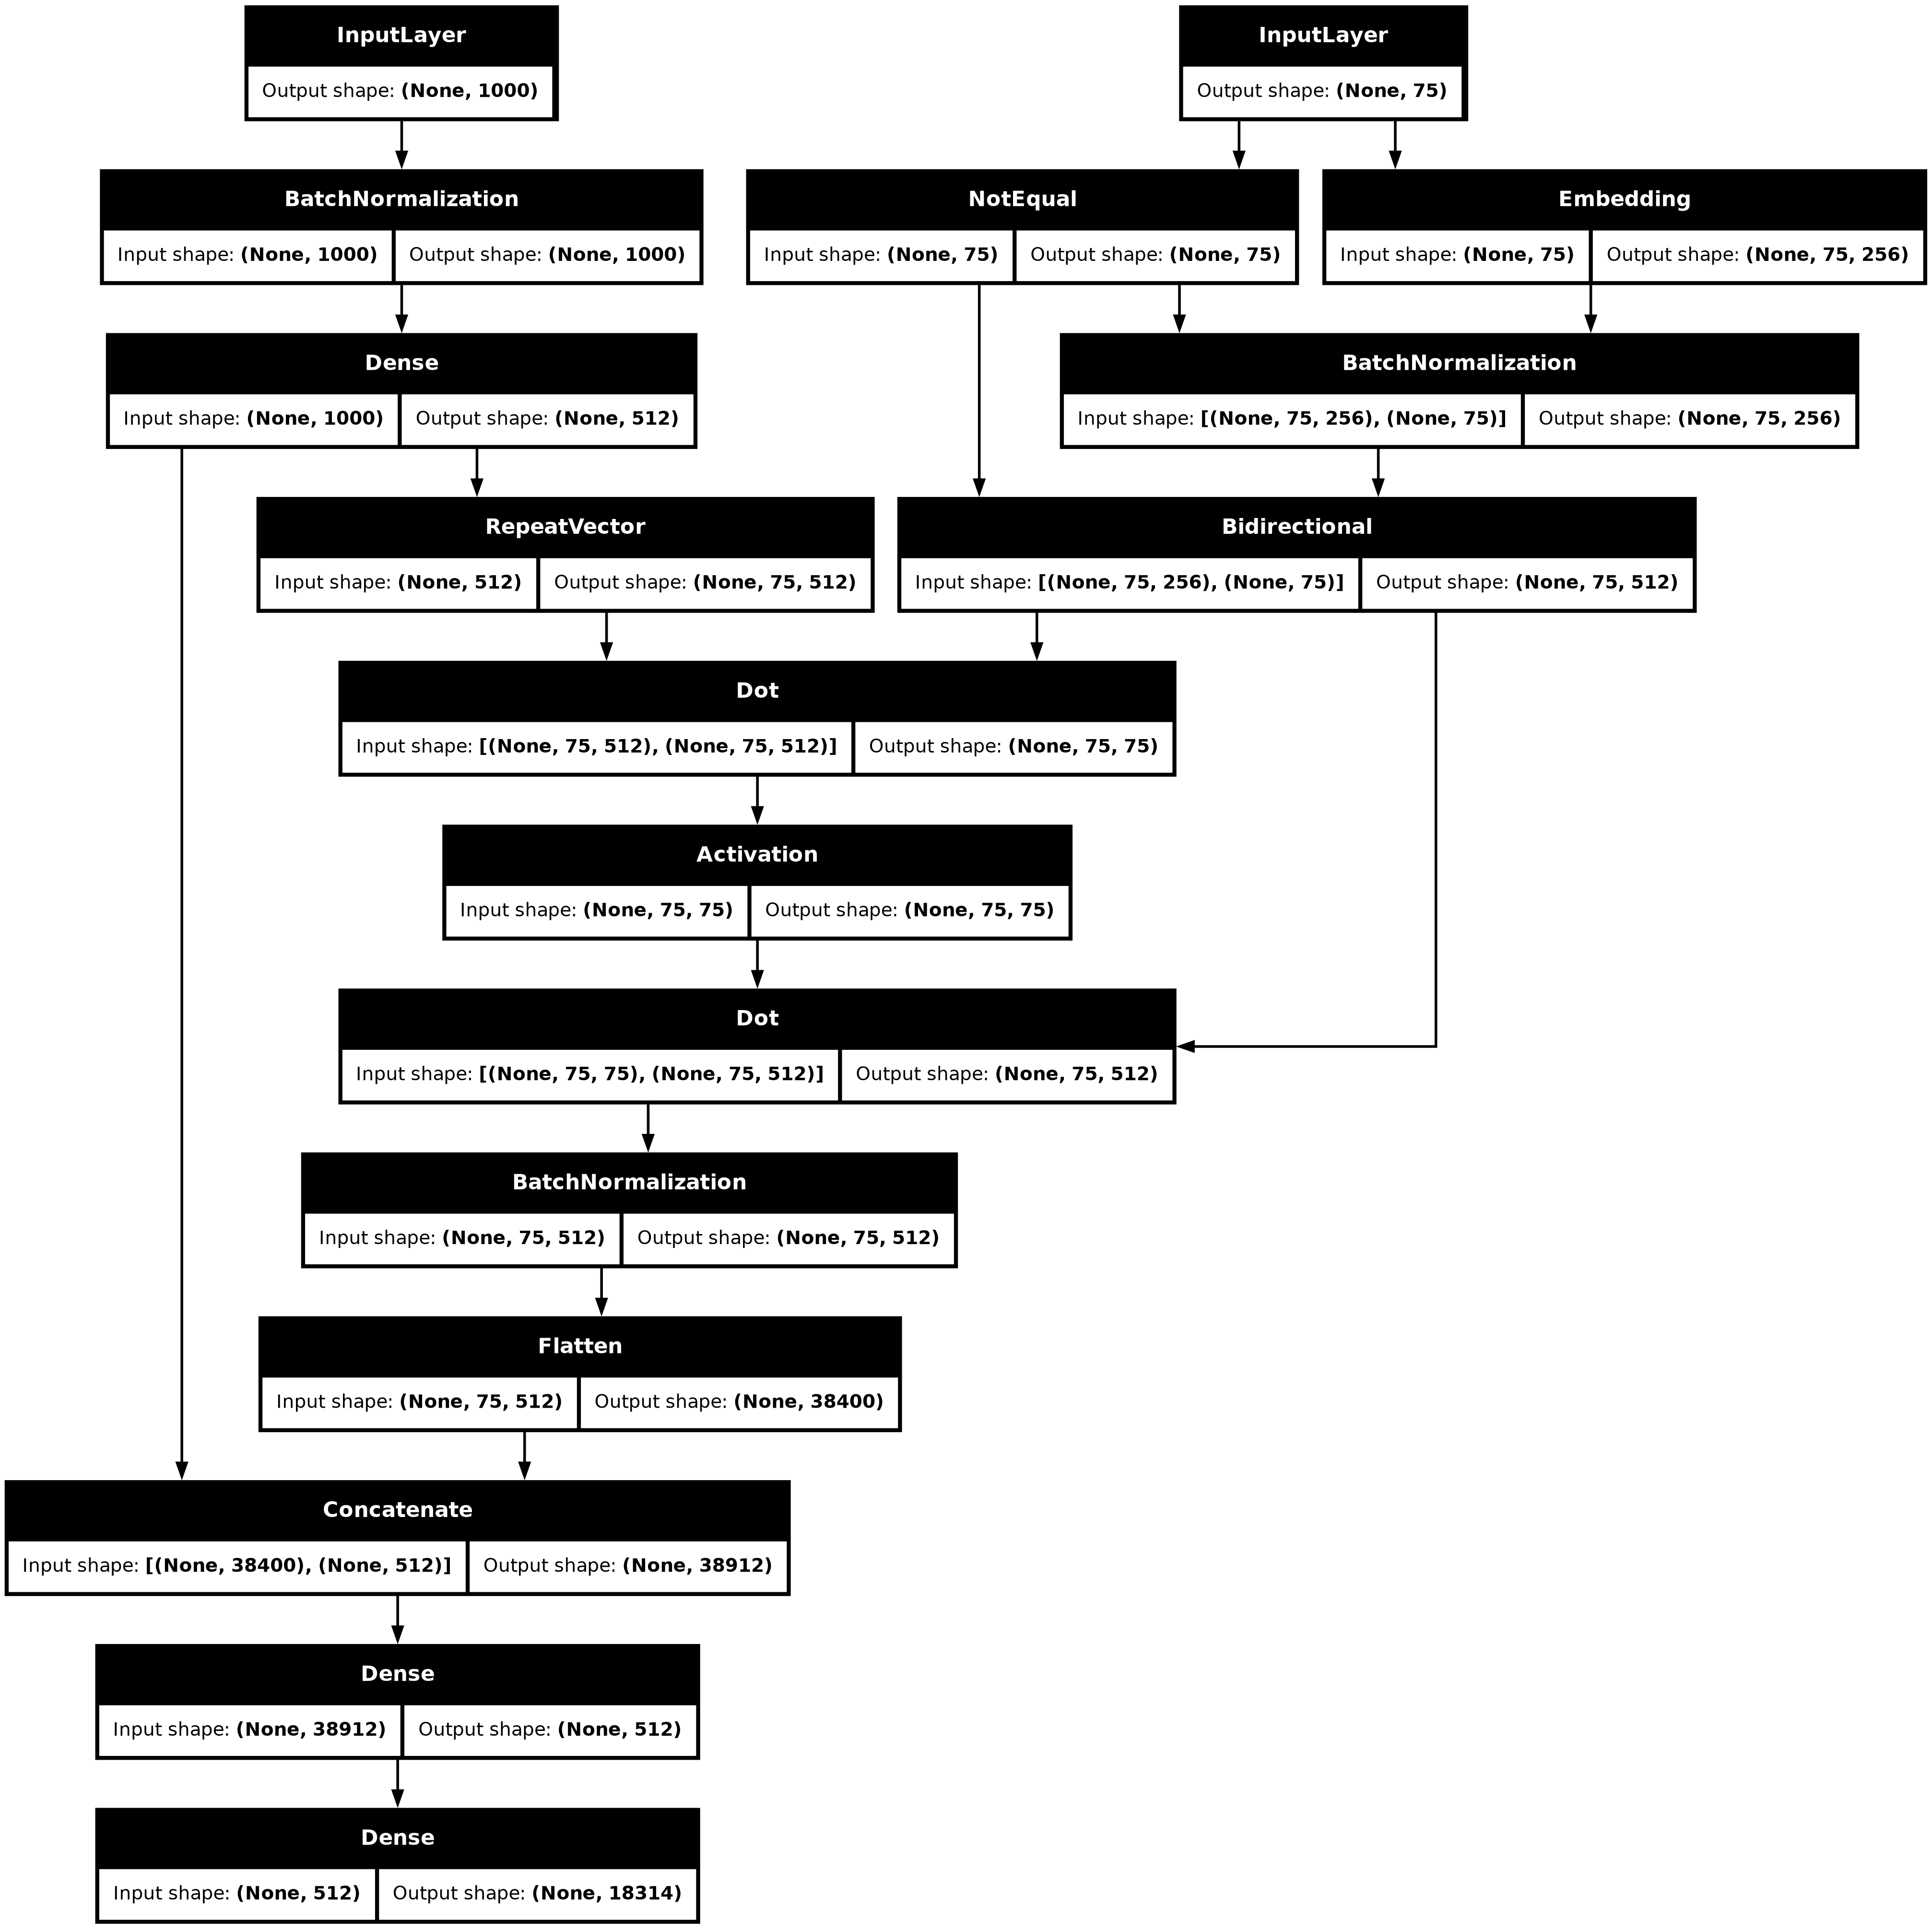

In [16]:
inputs1 = Input(shape=(1000,),name='image')
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
fe2_projected = RepeatVector(max_length)(fe2)

inputs2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([fe2_projected, se3])
attention = Activation('softmax')(attention)
context_vector = Dot(axes=[1, 1])([attention, se3])
context_vector = BatchNormalization()(context_vector)


context_vector = tf.keras.layers.Flatten()(context_vector)
decoder1 = Concatenate()([context_vector, fe2])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

plot_model(model, show_shapes=True)


In [17]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

history = History()

for i in range(epochs):
    generator = data_generator2(train, mapping, features2, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[history])


893/893 ━━━━━━━━━━━━━━━━━━━━ 405s 446ms/step - accuracy: 0.2229 - loss: 4.8941
893/893 ━━━━━━━━━━━━━━━━━━━━ 407s 456ms/step - accuracy: 0.3206 - loss: 3.4723
893/893 ━━━━━━━━━━━━━━━━━━━━ 408s 456ms/step - accuracy: 0.3492 - loss: 3.0734
893/893 ━━━━━━━━━━━━━━━━━━━━ 406s 455ms/step - accuracy: 0.3779 - loss: 2.7715
893/893 ━━━━━━━━━━━━━━━━━━━━ 408s 456ms/step - accuracy: 0.4112 - loss: 2.5342
893/893 ━━━━━━━━━━━━━━━━━━━━ 409s 458ms/step - accuracy: 0.4399 - loss: 2.3561
893/893 ━━━━━━━━━━━━━━━━━━━━ 406s 454ms/step - accuracy: 0.4643 - loss: 2.2122
893/893 ━━━━━━━━━━━━━━━━━━━━ 407s 456ms/step - accuracy: 0.4841 - loss: 2.1009
893/893 ━━━━━━━━━━━━━━━━━━━━ 408s 457ms/step - accuracy: 0.5028 - loss: 2.0007
893/893 ━━━━━━━━━━━━━━━━━━━━ 408s 456ms/step - accuracy: 0.5199 - loss: 1.9130
893/893 ━━━━━━━━━━━━━━━━━━━━ 408s 456ms/step - accuracy: 0.5350 - loss: 1.8368
893/893 ━━━━━━━━━━━━━━━━━━━━ 409s 458ms/step - accuracy: 0.5473 - loss: 1.7701
893/893 ━━━━━━━━━━━━━━━━━━━━ 406s 454ms/step - accur

In [18]:
model.save('MobileNetmodelF.keras')

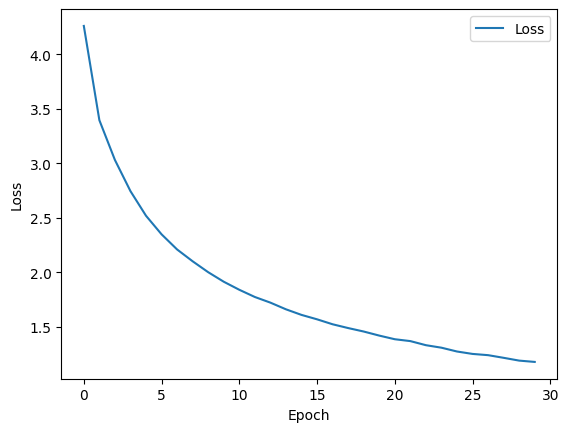

In [19]:
train_loss = history.history['loss']

plt.plot(train_loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


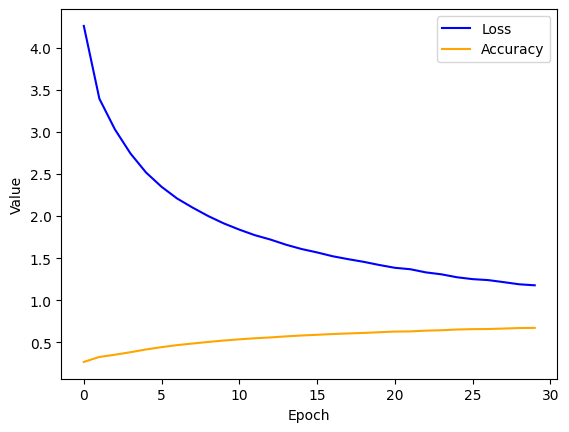

In [20]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

plt.plot(train_loss, label='Loss', color='blue')  
plt.plot(train_accuracy, label='Accuracy', color='orange')  

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()


In [21]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def predict_caption2(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length,padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text


In [22]:
def generate_caption2(image_name):
    image_id = image_name.split('.')[0]

    img_path = os.path.join(BASE_DIR, "Images","flickr30k_images", image_name)
    image = Image.open(img_path)

    prediction = predict_caption2(model, features2[image_id], tokenizer, max_length)
    caption_text = prediction.replace('startseq', '').replace('endseq', '').strip()
    
    
    print("Generated Caption:", caption_text)
    plt.axis('off')
    plt.imshow(image)
    plt.show()


    tts = gTTS(caption_text, lang='en')
    audio_path = "predicted_caption.mp3"
    tts.save(audio_path)

    print("Click to play audio:")
    display(Audio(audio_path))  
    print("\n\n")


Generated Caption: two young men are in garden with bushes


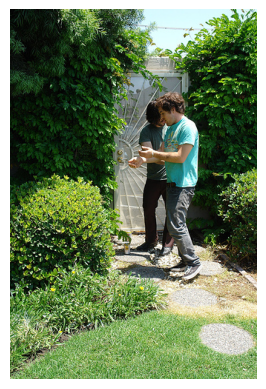

Click to play audio:





Generated Caption: woman in black shirt sprinkles powdered sugar onto cake


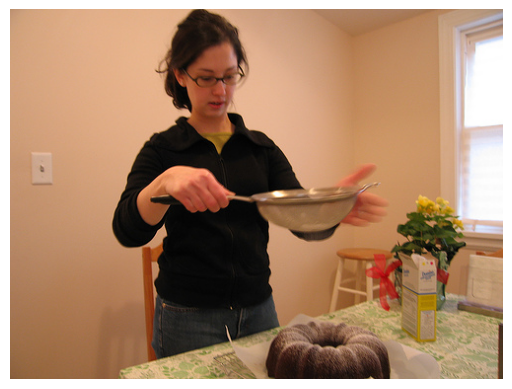

Click to play audio:





Generated Caption: man with glasses and white scarf is wearing hat


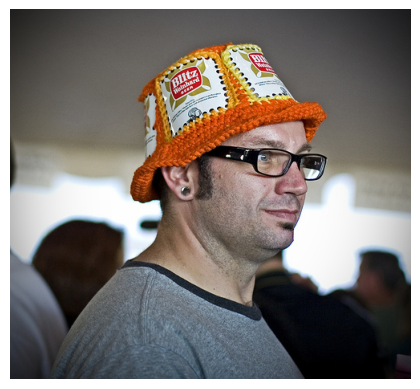

Click to play audio:





Generated Caption: blond woman is standing next to man in brown shirt


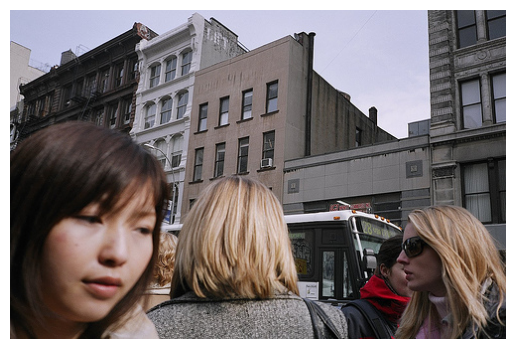

Click to play audio:


In [23]:
generate_caption2("1000092795.jpg")
generate_caption2("100207720.jpg")
generate_caption2("1007129816.jpg")
generate_caption2("100197432.jpg")

In [24]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption2(model, features2[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
mbbleu_1f = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
mbbleu_2f = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
mbbleu_3f = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
mbbleu_4f = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))


print("Final BLEU-1 for MobileNet: %f" % mbbleu_1f)
print("Final BLEU-2 for MobileNet: %f" % mbbleu_2f)
print("Final BLEU-3 for MobileNet: %f" % mbbleu_3f)
print("Final BLEU-4 for MobileNet: %f" % mbbleu_4f)


100%|██████████| 3179/3179 [38:38<00:00,  1.37it/s]


Final BLEU-1 for MobileNet: 0.478070
Final BLEU-2 for MobileNet: 0.237563
Final BLEU-3 for MobileNet: 0.131043
Final BLEU-4 for MobileNet: 0.068956


In [25]:
mobilenet_bleu_scores = {
    'BLEU-1': mbbleu_1f,
    'BLEU-2': mbbleu_2f,
    'BLEU-3': mbbleu_3f,
    'BLEU-4': mbbleu_4f
}
with open('mobilenetv3_bleu_scoresf.pkl', 'wb') as f:
    pickle.dump(mobilenet_bleu_scores, f)

print("MobileNetV3 BLEU scores saved to mobilenetv3_bleu_scores.pkl")


MobileNetV3 BLEU scores saved to mobilenetv3_bleu_scores.pkl


Here we are done with MobileNetV3 Large